In [1]:
# auto-reload imports 
%load_ext autoreload
%autoreload 2

In [3]:

import mc.replay_analysis.functions.model_rdms as model_rdms
import mc.replay_analysis.functions.data_rdms as data_rdms
import mc.analyse.analyse_MRI_behav as analyse_MRI_behav
from mc.analyse.searchlight import get_volume_searchlight
import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm
sns.set_style('dark')
# from rsatoolbox.util.searchlight import get_volume_searchlight
from nilearn.image import load_img

In [123]:
SUB = "sub-02"
SUBJECT_DIRECTORY = '/Users/student/PycharmProjects/data/derivatives/' + SUB + '/'
EVS_TYPE = 'instruction_period'
TASK_HALVES = ['1', '2']
RDM_VERSION = '01'

## Get the EVs Dictionary 
Make sure that out conditions are labeled
Remove the task halves. Just have a naming convention that keeps track of this. 

In [124]:
# Create dictionary to store the data for each EV for both task halves
# Convert the output of this to be pandas arrays

EVs_both_halves_dict = {
    '1': None,
    '2': None
}
# create new dictionary to store the 2D array of EVs for both task halves
EVs_both_halves_2d = EVs_both_halves_dict.copy()

    
EVs_path_dict = data_rdms.get_EV_path_dict(
    subject_directory = SUBJECT_DIRECTORY,
    EVs_type = EVS_TYPE
    )

# Load in the EVs for the instruction periods from the dictionary of paths
EVs_data_dict = data_rdms.load_EV_data(
    EVs_path_dict = EVs_path_dict,
    RDM_VERSION = RDM_VERSION
)

# Unravel the values of each EV
EVs_data_dict = data_rdms.unravel_EV_data(EVs_data_dict)
EVs_data_dict = pd.DataFrame(EVs_data_dict)


# get column names
column_names = EVs_data_dict.columns.tolist()
for idx, name in enumerate(column_names):
    column_names[idx] = name[3:7]
    

# column_names
EVs_data_dict.rename(columns=dict(zip(EVs_data_dict.columns.tolist(), column_names)), inplace=True)

conditions = [
        'A1_f', 'A1_b',
        'B1_f', 'B1_b',
        'C1_f', 'C1_b',
        'D1_f', 'D1_b',
        'E1_f', 'E1_b',
        'A2_f', 'A2_b',
        'B2_f', 'B2_b',
        'C2_f', 'C2_b',
        'D2_f', 'D2_b',
        'E2_f', 'E2_b',    
    ]

# reorder the columns 
EVs_data_dict.loc[:, conditions]


# EVs_data_dict[]

,A1_f,A1_b,B1_f,B1_b,C1_f,C1_b,D1_f,D1_b,E1_f,E1_b,A2_f,A2_b,B2_f,B2_b,C2_f,C2_b,D2_f,D2_b,E2_f,E2_b
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
746492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
746493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
746494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Get the Searchlights
- Requires the mask file

In [172]:
# Load binary mask of the brain
mask = load_img(f"{SUBJECT_DIRECTORY}/anat/{SUB}_T1w_noCSF_brain_mask_bin_func_01.nii.gz")
print(mask.shape)
mask = mask.get_fdata()
print(mask.shape)




(108, 108, 64)
(108, 108, 64)


In [173]:

# Get list of voxel centers and their volume neighbours
center, vol_neighbors = get_volume_searchlight(
    mask = mask,
    radius = 3,
    threshold = 0.5)


Finding searchlights...: 100%|██████████| 168204/168204 [00:08<00:00, 20226.33it/s]


Found 166240 searchlights


ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

In [176]:
l = [len(n) for n in vol_neighbors] # check that all voxels have the same number of neighbours

# count the number of unique elements in the list
from collections import Counter
Counter(l)




Counter({93: 166240})

In [158]:

# x, y, z = mask.shape
# points = np.zeros(x * y * z)
# for center in list_of_centers:
#     points[center] = 1

# points = points.reshape(x, y, z)
# # save the points to a nifti file
# img = nib.Nifti1Image(points, mask.affine)
# nib.save(img, f"{SUBJECT_DIRECTORY}/points.nii.gz")

In [117]:
# # Remove the voxels that do not have 93 neighbours
# new_vol_neighbors = [vol_neighbors[i] for i in range(len(vol_neighbors)) if len(vol_neighbors[i]) == 93]
# new_center = [center[i] for i in range(len(vol_neighbors)) if len(vol_neighbors[i]) == 93]

# len(new_vol_neighbors), len(new_center)


(162243, 162243)

In [177]:
# # Create a data frame to store the searchliht data inside of
# # Indicies of the searchlights
# vol_searchlight = {}
# for center, vol_neigh in zip(new_center, new_vol_neighbors):
# # for center, vol_neigh in zip(centers, vol_neighbors):
#     vol_searchlight[center] = vol_neigh

# vol_searchlight = pd.DataFrame(vol_searchlight)

# len(list(vol_searchlight.columns))


162243

In [100]:
# len(vol_searchlight.columns)
# vol_searchlight

AttributeError: 'dict' object has no attribute 'columns'

In [13]:

# For each centre, there is a column of the df which contains the unraveled indices of the voxels in the neighbourhood
# vol_searchlight

## Get the EVs (subset) for each searchlight
compute the RDM for each searchlight


In [4]:
# from the vol_searchlights that are generated from the masks, we can convert them to the data searchlights
# They the table has the same formatting as the vol_searchlight table, but the values are the EVs data (bold signal for the conditions)
# The data_searchlight table will be used to calculate the RDMs for each searchlight

data_searchlight = data_rdms.get_data_searchlight(
    vol_searchlight = vol_searchlight,
    EVs_data_dict = EVs_data_dict,
)


type(data_searchlight)

# took 9 mins to run on 126363 voxels

NameError: name 'vol_searchlight' is not defined

In [179]:

import pickle
# save data_searchlight to a pickle file
with open(f"{SUBJECT_DIRECTORY}/searchlight_data_searchlight.pkl", 'wb') as f:
    pickle.dump(data_searchlight, f)

# # load data_searchlight from a pickle file
# with open(f"{SUBJECT_DIRECTORY}/searchlight_data_searchlight.pkl", 'rb') as f:
#     data_searchlight = pickle.load(f)


In [48]:
len(data_searchlight.keys())    

162243

## Get the RDMs for each searchlight
- Data structure here, requires that the RDMs have condition labels (that will come from the EVs condition labels)

In [197]:
# create test df of EVs for the conditons
# data_searchlight = dict(data_searchlight.items()[:100])

# create dictionary of data rdms
data_rdms_dict = data_rdms.get_data_rdms(
    data_searchlight = data_searchlight,
    SIZE = 'between_halves'
    )
# What should the labels be for the data RDMs in the dictionary

In [65]:
# cross validation
len(data_rdms_dict.keys())
# data_rdms_dict[161427]

162243

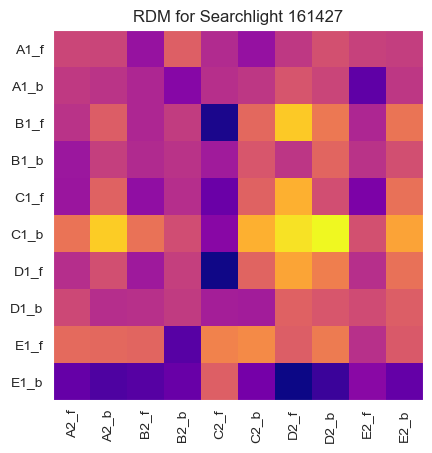

In [ ]:

# Plot the searchlight RDM
center = 161427

data_rdms.plot_rdm(
    df = data_rdms_dict,
    idx = center,
    SIZE = 'between_halves'
    )

In [181]:
# convert to triangle vectors for RSA
data_rdms_tri = data_rdms.get_data_rdms_tri(
    data_rdms_dict = data_rdms_dict
    )
# Confirm the labels are the correct way around. Are the X labels swapped with the Y labels?
# data_rdms_tri


In [88]:
len(data_rdms_tri.columns)

162243

In [25]:
# This function is returnin the wrong labels. 
# plt.figure(figsize=(50, 50), dpi=300)
# plt.imshow(data_rdms_tri)
# plt.xticks(np.arange(0, len(data_rdms_tri.columns), 1), labels = data_rdms_tri.columns, rotation = 90)
# plt.yticks(np.arange(0, len(list(data_rdms_tri.index)), 1), labels = list(data_rdms_tri.index))
# plt.show()

# get the model RDM


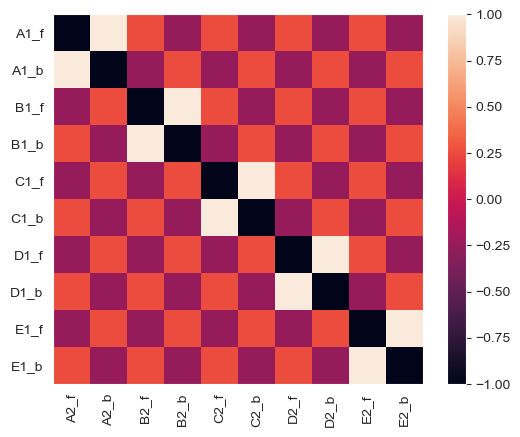

In [182]:
conditions = [
        'A1_f', 'A1_b',
        'B1_f', 'B1_b',
        'C1_f', 'C1_b',
        'D1_f', 'D1_b',
        'E1_f', 'E1_b',
        'A2_f', 'A2_b',
        'B2_f', 'B2_b',
        'C2_f', 'C2_b',
        'D2_f', 'D2_b',
        'E2_f', 'E2_b',    
    ]

# RETURNING THE INCORRECT DICTIONARY. GETTING AN ERROR
model_rdms_dict = model_rdms.get_model_rdms(conditions, 'replay', SIZE = 'between_halves')

model_rdms_dict_tri = data_rdms.get_data_rdms_tri(model_rdms_dict)


# plt.figure(figsize=(50, 50))
plt.imshow(model_rdms_dict['replay'])
plt.yticks(np.arange(0, len(list(model_rdms_dict['replay'].index)), 1), list(model_rdms_dict['replay'].index))
plt.xticks(np.arange(0, len(model_rdms_dict['replay'].columns), 1), model_rdms_dict['replay'].columns, rotation = 90)
# add color bar
plt.colorbar()

plt.show()

# model_rdms_dict_tri['replay']


Evlaluation function with the model rdm

In [2]:
# import statsmodels.api as sm

# def evaluate_model(
#         Y,
#         X 
#         ):
#     """
#     Evaluates fit of model to data using OLS regression.
    
#     Predicting the data from the model
#     Y (data) = bX (model) + C

#     Parameters
#         model: 
#         data

#     Returns
#         tvalues
#         betas
#         pvalues
#     """
    
#     # model = sm.add_constant(model.rdm.transpose());
#     # data = data.dissimilarities.transpose();
    
#     # to filter out potential nans in the model part
#     # nan_filter = np.isnan(model).any(axis=1)
#     # filtered_model = model[~nan_filter]
#     # filtered_data = data[~nan_filter]
    
#     # estimate OLS model
#     # est = sm.OLS(filtered_data, filtered_model).fit()
#     # print(X)
#     # print(Y)

#     # Y = Y.reset_index(drop=True)
#     # Y = sm.add_constant(Y) 

#     # X = X.reset_index(drop=True)
#     X = sm.add_constant(X)
#     # print(X.shape, Y.shape)

#     nan_filter = np.isnan(X).any(axis=1)
#     X = X[~nan_filter]
#     Y = Y[~nan_filter]

#     est = sm.OLS(Y, X)
#     est = est.fit()
    
#     # return the tvalues, betas and pvalues
#     return est.tvalues[1:], est.params[1:], est.pvalues[1:]


eval_result = []

for center in tqdm(data_rdms_tri.columns, desc = "Data Searchlights Running"):
    # print(data_rdms_tri[searchlight])
    # print(model_rdms_dict_tri['replay'])
    eval_result.append(
        data_rdms.evaluate_model(
        Y = data_rdms_tri[center],          # Get the data RDM for that center
        X = model_rdms_dict_tri['replay']   # Get the model RDM (the same for each centre)
        )
    )
    # break
# eval_result = Parallel(n_jobs=3)(delayed(evaluate_model)(
#     Y = model_rdms_dict_tri['replay'],                            # Model that is being evaluated              
#     X = data_rdms_tri[searchlight]
#     ) for searchlight in tqdm(data_rdms_tri.columns, desc = "Data Searchlights Running"))   # (from the list of data RDMs)




NameError: name 'tqdm' is not defined

In [186]:
# data_rdms_tri.columns
len(eval_result)

162243

Need to work out how the evaluation function works to fit the model

In [5]:
mask = load_img(f"{SUBJECT_DIRECTORY}/anat/{SUB}_T1w_noCSF_brain_mask_bin_func_01.nii.gz")


def save_RSA_result(
    results_file = eval_result, 
    data_rdms_tri = data_rdms_tri,
    mask = mask,         
    results_directory = '/Users/student/PycharmProjects/data/derivatives/sub-02/func/RSA_replay/'
    ):

    # get the shape of the brain to be saved into
    x, y, z = mask.shape

    # Create a 1D array of the brain that will store the results
    t_values = np.zeros([x * y * z])
    b_values = np.zeros([x * y * z])
    p_values = np.zeros([x * y * z])
    # for each value in the data_rdms_tri.columns we have the tvalues, betas and pvalues in the eval_result list, inorder
    for idx, centers in enumerate(data_rdms_tri.columns):
        # Unpack each value from the 3 x 1 tuple list and store them in the 1D arrays of the same size as the brain 
        t_values[centers] = results_file[idx][0]
        b_values[centers] = results_file[idx][1]
        p_values[centers] = results_file[idx][2]

    # reshape the 1D arrays to the shape of the brain
    t_values = np.reshape(t_values, mask.shape)
    b_values = np.reshape(b_values, mask.shape)
    p_values = np.reshape(p_values, mask.shape)

    print(t_values.shape)

    # save the results to a nifti file
    t_values = nib.Nifti1Image(t_values, mask.affine)
    b_values = nib.Nifti1Image(b_values, mask.affine)
    p_values = nib.Nifti1Image(p_values, mask.affine)

    # save results to the correct directory of the brain 
    nib.save(t_values, results_directory + 't_values.nii.gz')  
    nib.save(b_values, results_directory + 'b_values.nii.gz')
    nib.save(p_values, results_directory + 'p_values.nii.gz')


data_rdms.save_RSA_result(
    results_file = eval_result, 
    data_rdms_tri = data_rdms_tri,
    mask = mask,         
    results_directory = '/Users/student/PycharmProjects/data/derivatives/sub-02/func/RSA_replay/'
    )




eval_result[0]
    

NameError: name 'SUBJECT_DIRECTORY' is not defined

In [119]:
# for center in data_rdms_tri.columns:
#     print(center)
#     print(data_rdms_tri[center])

#     center = 161427
#     # print(model_rdms_dict_tri['replay'])
#     break
len(data_rdms_tri.columns)  

162243

In [81]:
center = 161427
coord = np.unravel_index(center, mask.shape)
coord, mask.shape

((23, 38, 19), (108, 108, 64))

Something to do with the size of the area that is being masked. 